In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile
from imblearn.over_sampling import SMOTE

In [196]:
file = '/Users/tshields/Documents/GitHub/Churn/Data/churn_data_cleaned.csv'

In [197]:
df = pd.read_csv(file, index_col=0)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


# Dropping customerID 
The columnID feature is not necessary for EDA.   

In [199]:

df.drop(['customerID'], axis=1, inplace=True)

# What are the churn numbers?

The percentage of customer churn:
 No      73.42150170648463%
Yes    26.578498293515356%
Name: Churn, dtype: object
Total count of churners:
 No     5163
Yes    1869
Name: Churn, dtype: int64


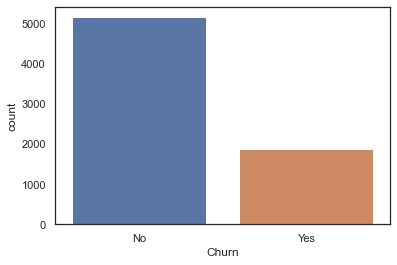

In [200]:
sns.countplot(x="Churn", data=df)
print('The percentage of customer churn:\n', df['Churn'].value_counts(normalize=True).mul(100).astype(str)+'%')
print('Total count of churners:\n',df.Churn.value_counts())


Roughly one quarter of all customers churn. To find out why, let's look at how the data releates to each other.

## Function for Quick Analysis

In [201]:
def plot_categoritical_and_numerical_features(d): # df is the input for this function. this input must be a dataframe
    cat = d.select_dtypes('object') # cat means categorical. this line will pull only categorical data from df
    cols = cat.columns # pulls the names of all the columns in df that are categorical
    for col in cols: # loop through all the columns in the cat
        ax = cat[col].value_counts().plot(kind='bar') # this step will plot a bar plot since the df is cat at this point
        ax.set_title('Proportion of {}'.format(col)) # naming the plot
        plt.xlabel('{}'.format(col)) # naming the x axis
        plt.ylabel('Frequency of {}'.format(col)) # naming the y axis
        plt.show() # displying the plot
        
    num = d._get_numeric_data() # pulling only the numerical data from df
    num_cols = num.columns # getting the names of the columns that are numerical
    for col in num_cols:
        x=num[col].plot()
        x.set_title('{} behavoir'.format(col))
        plt.xlabel('{}'.format(col))
        plt.ylabel('{}'.format(col))
        plt.show()

### What is the degree of correlation between the available data points and customer churn?



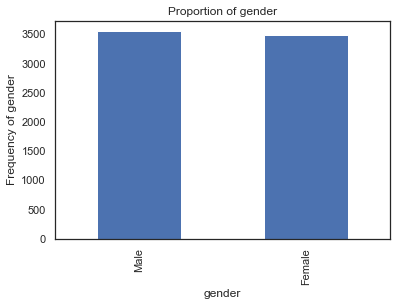

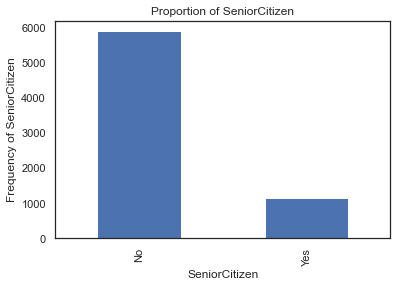

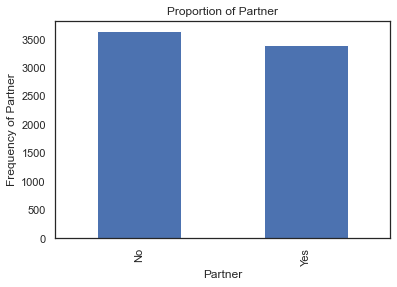

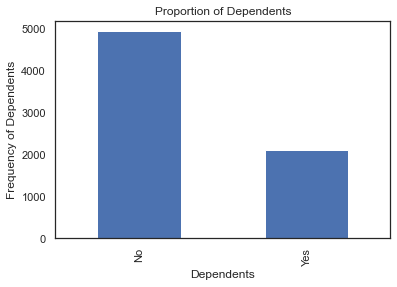

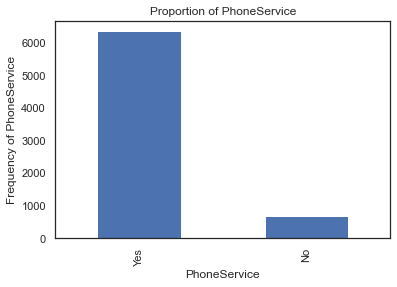

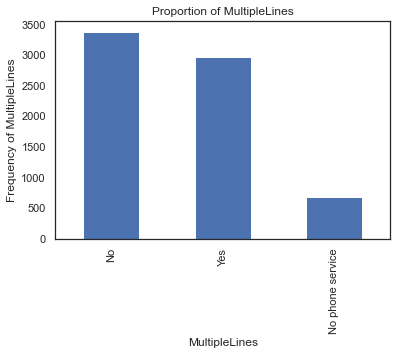

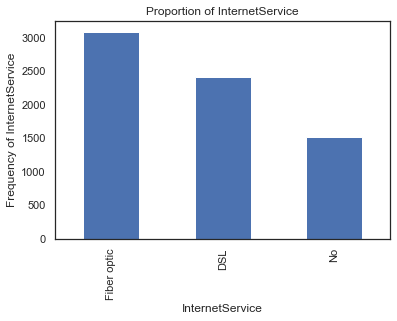

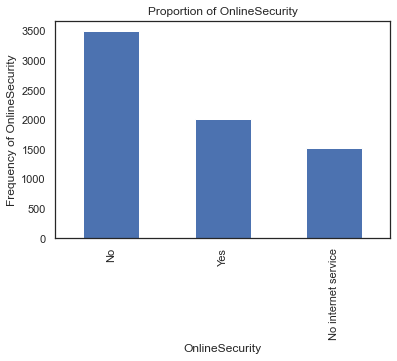

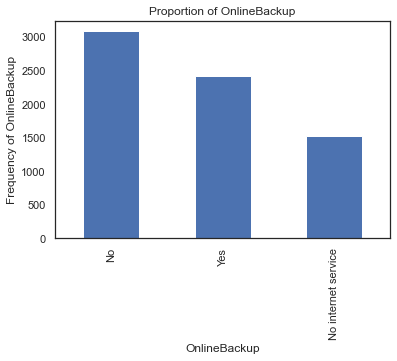

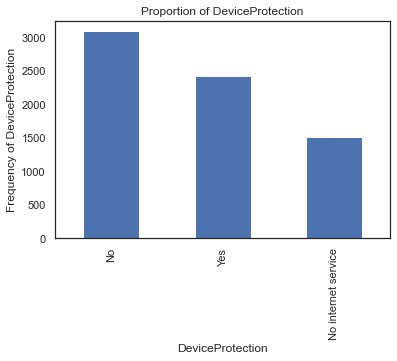

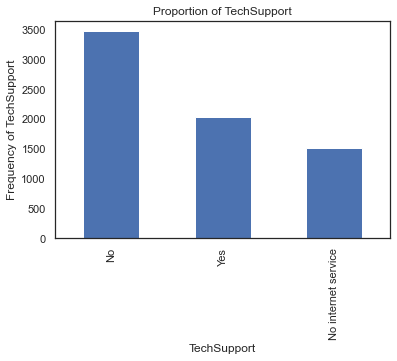

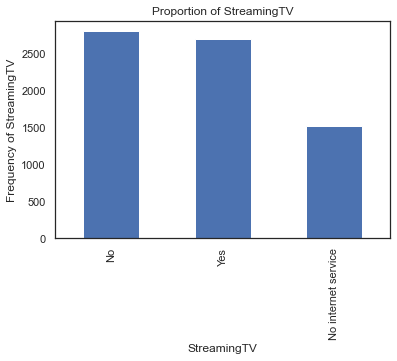

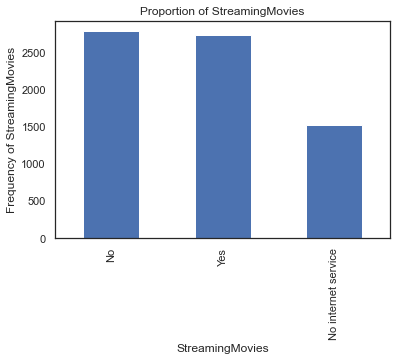

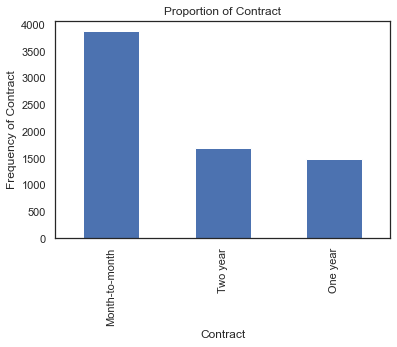

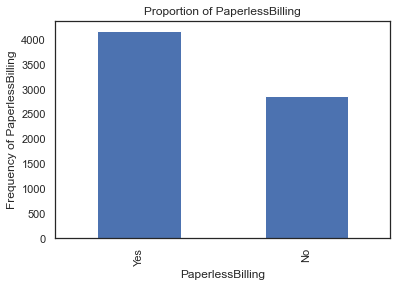

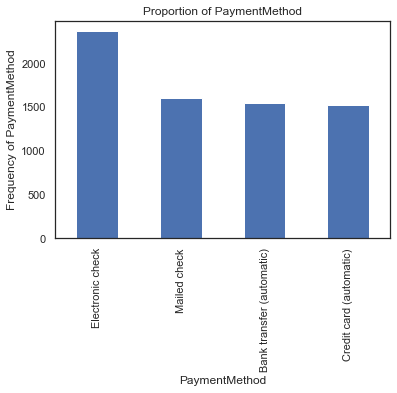

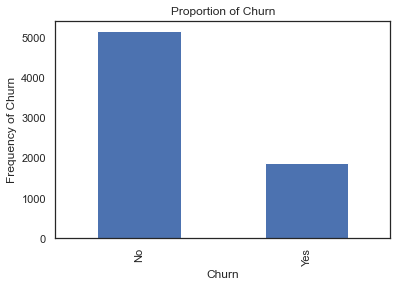

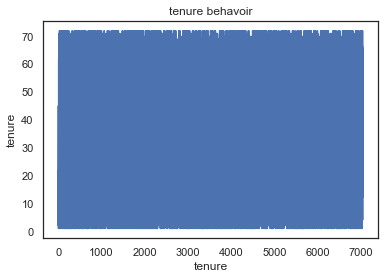

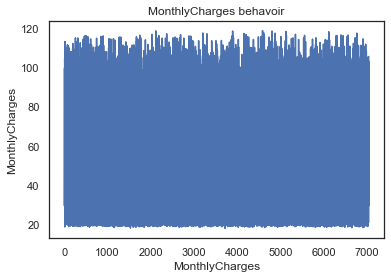

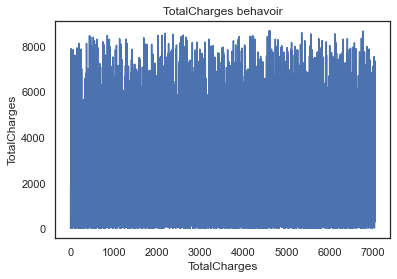

In [202]:
plot_categoritical_and_numerical_features(df)

#### Generalizations

Most customers:

Do not have dependents

Have a phone service

Have some sort of internet service

Do not use online security, online backup, device protection,tech support

Most are on to month to month contracts and paperless billing

Most pay using electronic check



### The numeric data is difficult to read 
Let's seperate the numeric and categorical data so that we can take a better look at the data.


# Seperating Numeric and Categorical Data

In [215]:
numeric = [
    'tenure', 'MonthlyCharges', 'TotalCharges'
]

categorical = [
  cat for cat in df.columns if df[cat].dtype=='object' and cat!='Churn'
]
print('Numeric Features: ', numeric)
print('Categorical Features: ', categorical)


Numeric Features:  ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Features:  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


# Correlation Between Numeric Variables

Text(0.5, 1.0, 'Multi-Collinearity of Features')

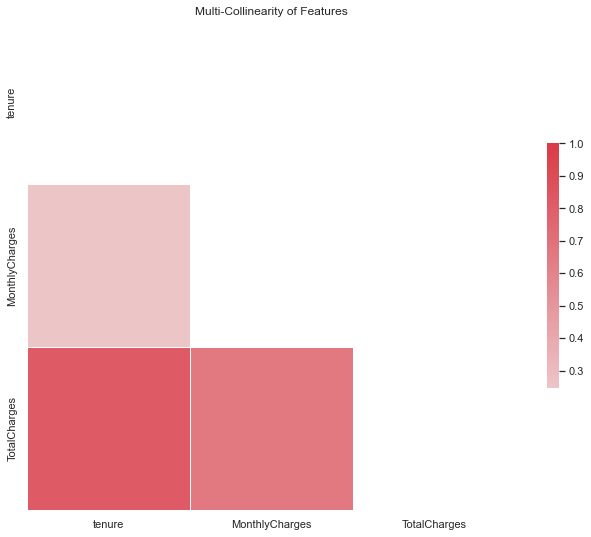

In [216]:
sns.set(style="white")
corr = df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=1,center=0,square=True, 
            linewidth=.5, cbar_kws={'shrink': .5})
ax.set_title('Multi-Collinearity of Features')

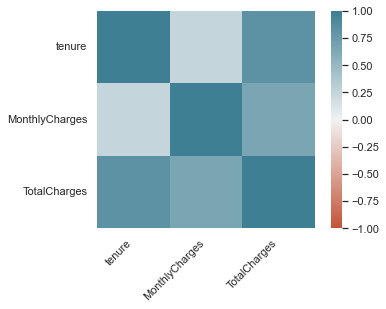

In [217]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

array([[<AxesSubplot:xlabel='tenure', ylabel='tenure'>,
        <AxesSubplot:xlabel='MonthlyCharges', ylabel='tenure'>,
        <AxesSubplot:xlabel='TotalCharges', ylabel='tenure'>],
       [<AxesSubplot:xlabel='tenure', ylabel='MonthlyCharges'>,
        <AxesSubplot:xlabel='MonthlyCharges', ylabel='MonthlyCharges'>,
        <AxesSubplot:xlabel='TotalCharges', ylabel='MonthlyCharges'>],
       [<AxesSubplot:xlabel='tenure', ylabel='TotalCharges'>,
        <AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>,
        <AxesSubplot:xlabel='TotalCharges', ylabel='TotalCharges'>]],
      dtype=object)

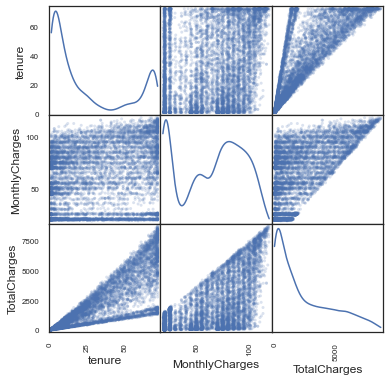

In [218]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha = 0.2, figsize = (6, 6), diagonal = 'kde')

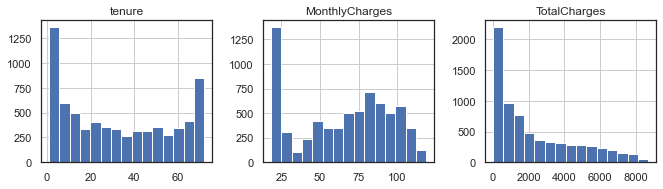

In [219]:
df[numeric].hist(bins=15, figsize=(15, 6), layout=(2, 4));

### Numeric Data Generalizations

Tenure: It appears those who churn, churn early, the spike at the tail could be customers who age out

Monthly chares: It appears most who churn have lower montly balances

Total charges: It is logical that those who churn spend less money in total



# Correlation Between Categorical Variables

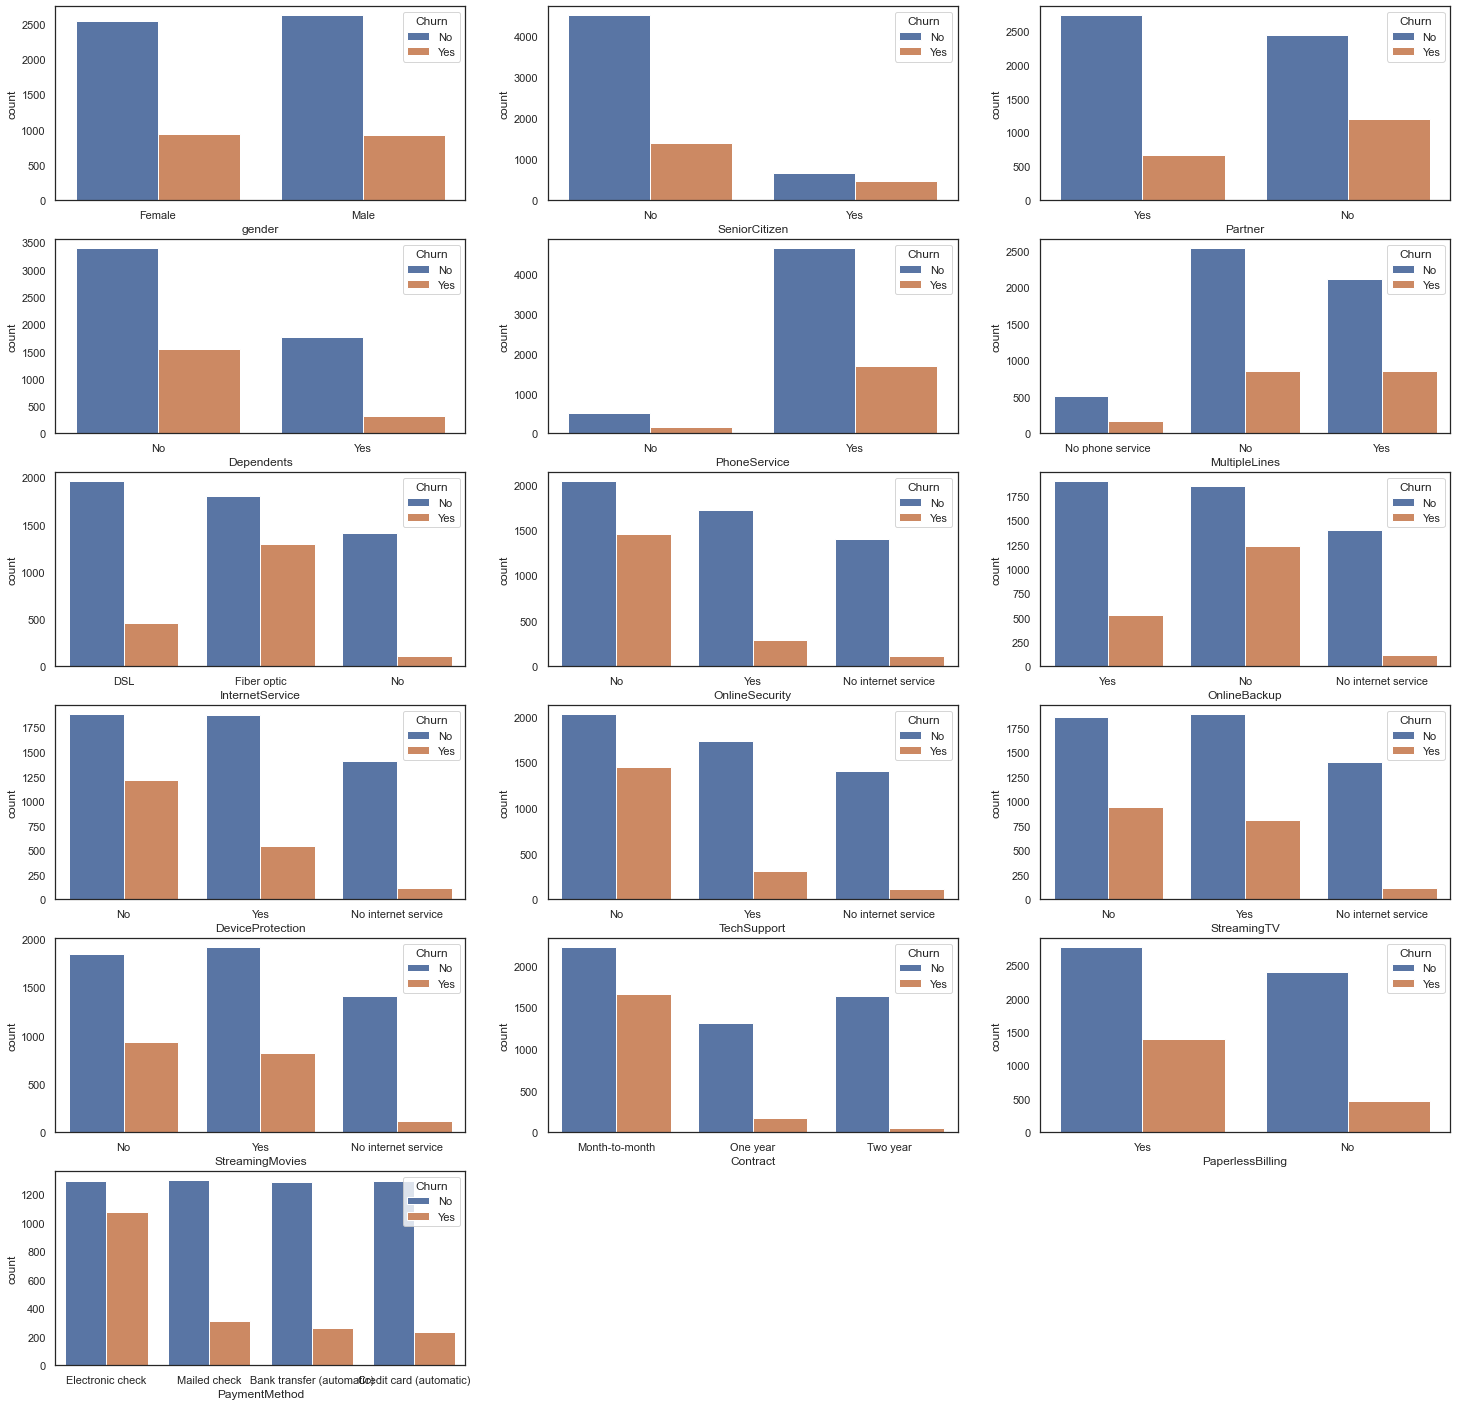

In [220]:
plt.figure(figsize=(25,25))
for i,cat in enumerate(categorical):
    plt.subplot(6,3,i+1)
    sns.countplot(data = df, x= cat, hue = "Churn")
plt.show()

### A closer look at categorical data

There are some new insights seen with this group of graphs.

Most of those who churn no only have internet service, but specifically fiber optic service.



# Hierarchical relationships among variables

#### A Heatmap for all Features

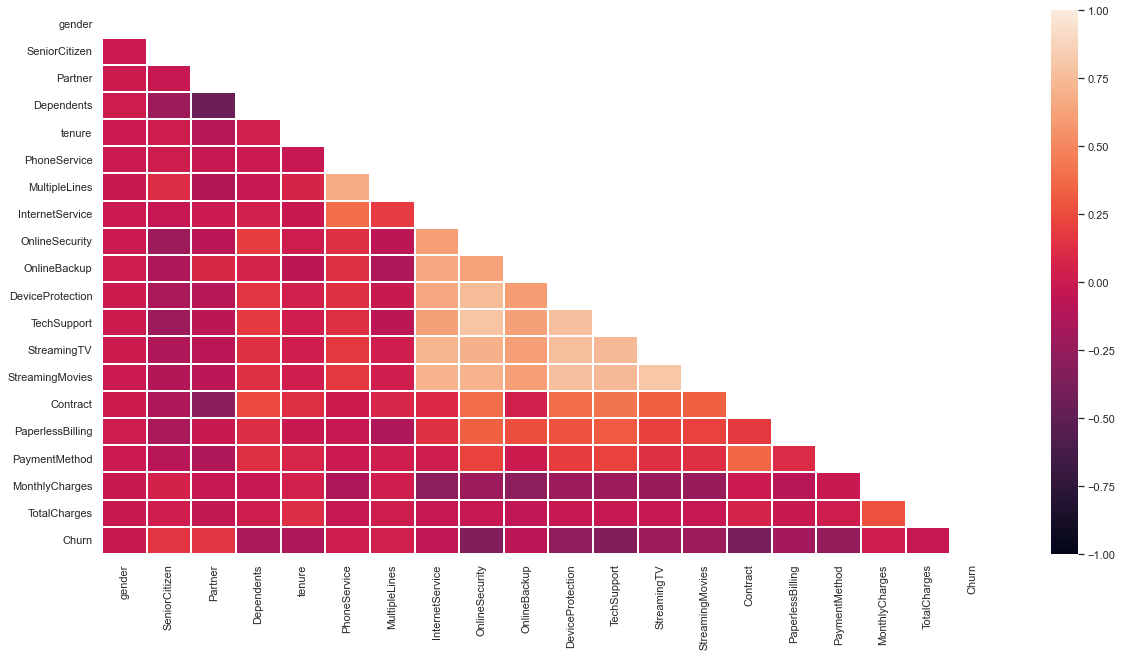

In [221]:
plt.figure(figsize=(20, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

dfax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.2,  vmin=-1, vmax=1)

### Heatmap Conclusions

Correleations:

Internet service which logically correlates with streaming movies & tv, tech support device protection online backup and security

Device protection correlates with online backup and security as these are all purchases of the cautious



# A Close Examination of Tenure

<AxesSubplot:title={'center':'Tenure by Year'}, xlabel='tenure_by_year', ylabel='count'>

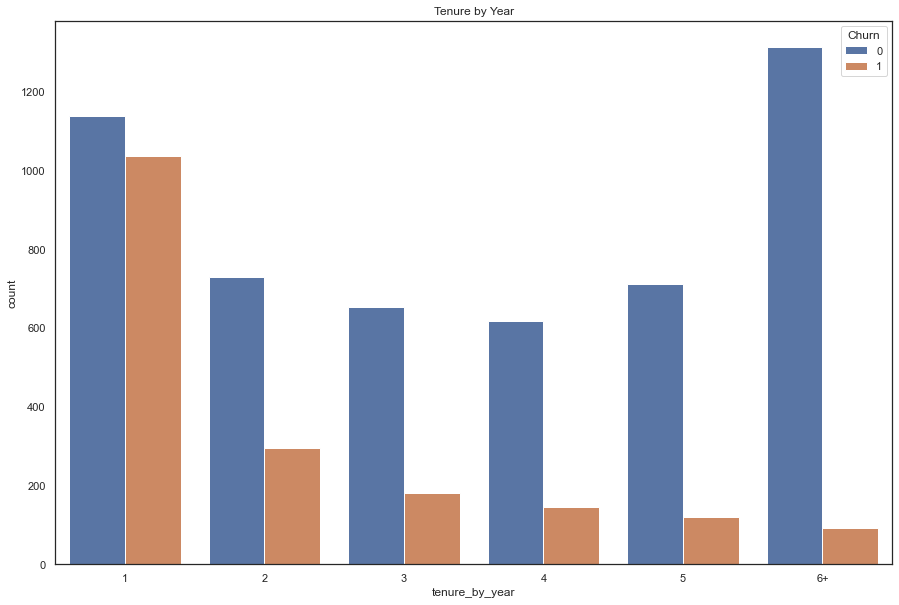

In [229]:
df['tenure_by_year'] = pd.cut(df['tenure'], bins=[0,12,24,36,48,60,np.inf], labels=['1', '2', '3', '4', '5', '6+'])
df['tenure_by_year'].value_counts()
plt.figure(figsize=(15,10))
plt.title('Tenure by Year')
sns.countplot(data=df, x='tenure_by_year',hue = "Churn")

As we can se clearly here, most people who churn do so within a year with it getting progressively less likely to happen each year afterward.

# Data Flow Diagram

# Use Cases
use cases are more about behavior that the technical team will have to build into the software.

# Suggested Feature Engineering 

# Feature Importance


In [224]:
#Mapping target feature
df['Churn']=df['Churn'].map({'No':0, 'Yes':1})
#convert categorical data into dummy variables
dummy = pd.get_dummies(df,drop_first=True)
dummy.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_grp_13-24,tenure_grp_25-36,tenure_grp_37-48,tenure_grp_49-60,tenure_grp_60+
0,1,29.85,29.85,0,0,0,1,0,0,1,...,0,1,0,1,0,0,0,0,0,0
1,34,56.95,1889.50,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
2,2,53.85,108.15,1,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
3,45,42.30,1840.75,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,2,70.70,151.65,1,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0


 What is the impact on Lifetime Value (LTV) of different customer segments?

# Evaluation of Solution Impact
Identify if A/B testing is needed to evaluate ‘before’ and ‘after’ scenarios 
Identify KPIs that are expected to either increase or decrease and implement processes to capture and compare them
What Are the 5 Key Performance Indicators?
Revenue growth.
Revenue per client.
Profit margin.
Client retention rate.
Customer satisfaction.


Can we identify customers in danger of churning?

Churn is a classification problem. A supervised decision tree/random forest model will be best? Logistic Regression?  Light Gradient Boosting, catboost or XGBoost. Ensemble models?

Stages of machine learning

Description: collect data and describe it using charts and reports
Prediction: Find patterns and anticipate outcomes
Prescription: Decide what to do with your insights

Model:
Light Gradient Boosting on ElasticNet Predictions
Preprocessing: 
One-Hot Encoding | Numeric Data Cleansing | Standardize | Ordinal encoding of categorical variables | Elastic-Net Classifier (L2 / Binomial Deviance) | Light Gradient Boosting on ElasticNet Predictions

SMOTE is an abbreviation for Synthetic Minority Oversampling Technique.

SMOTE works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.
https://towardsdatascience.com/applying-smote-for-class-imbalance-with-just-a-few-lines-of-code-python-cdf603e58688

Non Linearity in feature relationships are observed which makes tree methods a good choice
There are few options to consider among tree methods
White Box (Completely Explainable Set of Rules) - Decision Tree
Ensemble Methods - Random Forest (With Bagging)


The over sample method improved the algorithm's performance